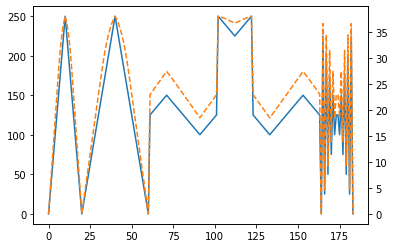

In [10]:
import torch
import pandas as pd
import numpy as np
from hysteresis.base import BaseHysteresis
from hysteresis.training import train_hysteresis
from hysteresis.visualization import plot_hysterion_density
import matplotlib.pyplot as plt

folder = f'D:/APS/Q7Hysteresis'
fnames = ['/APSU_Q7_100017035_MajorHysteresisLoop_0000_000_00_procFld_01.csv',
          '/APSU_Q7_100017035_MinorHysteresisLoop-1_0000_000_00_procFld_01.csv',
          '/APSU_Q7_100017035_MinorHysteresisLoop-2_0000_000_00_procFld_01.csv',
          '/APSU_Q7_100017035_MinorHysteresisLoop-3_0000_000_00_procFld_01.csv',
          '/APSU_Q7_100017035_HysteresisTrial-1_0000_000_00_procFld_01.csv',
          '/APSU_Q7_100017035_HysteresisTrial-2_0000_000_00_procFld_01.csv']

full_data = []
for fname in fnames:
    data = pd.read_csv(folder + fname, skiprows=5)
    data = data.drop([0])
    full_data += [data]

full_data = pd.concat(full_data, ignore_index=True)

# get real h, m
h = torch.tensor(full_data['Current'].to_numpy(dtype=np.float64))
m = torch.tensor(full_data['BigB1'].to_numpy(dtype=np.float64))

n_train = 61
h_train = h[:n_train]
m_train = m[:n_train]

fig, ax  = plt.subplots()
ax.plot(h)
axb = ax.twinx()
axb.plot(m,'--C1')

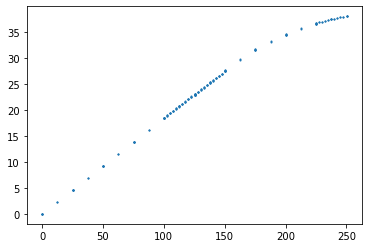

In [11]:
fig,ax = plt.subplots()
ax.plot(h, m,'o',ms=1)

0
1000
2000
7411
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


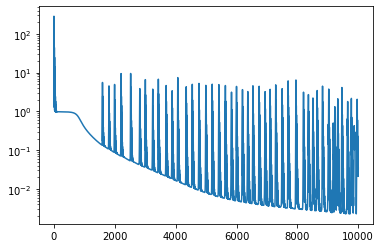

In [12]:
# fit using normal hysteresis model
H = BaseHysteresis(
    h_train,
    m_train,
    mesh_scale = 0.1,
    polynomial_degree=1,
    fixed_domain=torch.tensor((torch.min(h), torch.max(h)))
)
print(len(H.mesh_points))
# train on data
loss_trace = train_hysteresis(
    H,
    10000,
    lr=0.01,
    atol=1e-8,
)
fig, ax = plt.subplots()
ax.semilogy(loss_trace)

In [18]:
for name, value in H.named_parameters():
    print(f"{name}:{value}")

raw_hysterion_density:Parameter containing:
tensor([ 0.8146,  3.5171, -7.2796,  ...,  3.5553, -2.8469,  0.6736],
       requires_grad=True)
raw_offset:Parameter containing:
tensor([-0.0192], requires_grad=True)
raw_scale:Parameter containing:
tensor([-0.0182], requires_grad=True)
raw_slope:Parameter containing:
tensor([0.0345], requires_grad=True)
transformer._poly_fit.weights:Parameter containing:
tensor([0.1621])
transformer._poly_fit.bias:Parameter containing:
tensor([0.0059])


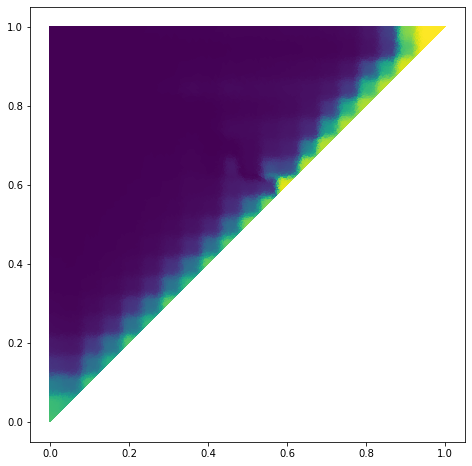

In [13]:
fig,ax,c = plot_hysterion_density(H)
ax.set_aspect('equal')
fig.set_size_inches(8,8)

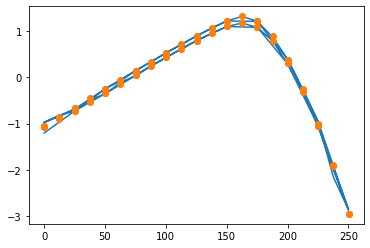

In [14]:
# plot regression
fig, ax = plt.subplots()
m_pred = H(h_train)
th, tm = H.transformer.transform(h_train, m_train)

ax.plot(h_train, m_pred.detach())
ax.plot(h_train, tm,'o')


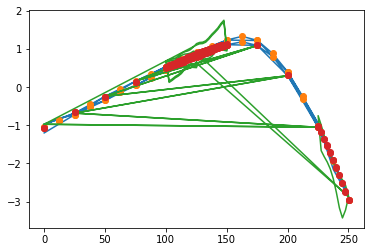

In [15]:
# plot prediction
fig2, ax2 = plt.subplots()
fig.set_size_inches(10,10)

H.regression()
m_regression = H(h)
th, tm = H.transformer.transform(h, m)

ax2.plot(h[:n_train], m_regression[:n_train].detach())
ax2.plot(h[:n_train], tm[:n_train],'o')

# plot future points
ax2.plot(h[n_train:], m_regression[n_train:].detach())
ax2.plot(h[n_train:], tm[n_train:],'o')


train RMS percentage error 1.1211451546646658
test RMS percentage error 6.160064821313698


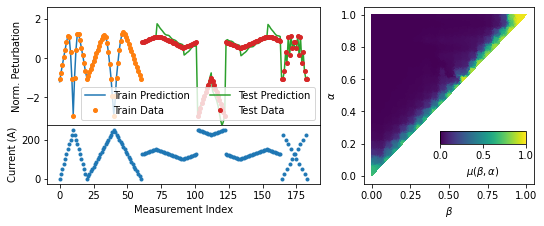

In [16]:
gridspec_kw = dict(height_ratios=[2,1], hspace=0.0,width_ratios=[2,1.25],right=0.97,
                   top=0.97,bottom=0.15,)
fig2 = plt.figure()
spec = fig2.add_gridspec(2,2, **gridspec_kw)

ax2 = fig2.add_subplot(spec[0,0])
ax3 = fig2.add_subplot(spec[1,0])
ax4 = fig2.add_subplot(spec[:,1])

fig2.set_size_inches(8,3)
ms=4
idx = torch.arange(len(tm))
ax2.plot(idx[:n_train], m_regression[:n_train].detach(), label='Train Prediction')
ax2.plot(idx[:n_train], tm[:n_train],'o',ms=ms, label='Train Data')

# plot future points
ax2.plot(idx[n_train:], m_regression[n_train:].detach(), label='Test Prediction')
ax2.plot(idx[n_train:], tm[n_train:],'o',ms=ms, label='Test Data')
ax2.set_ylabel('Norm. Peturbation')
w =  max(tm) - min(tm)
ax2.set_ylim(min(tm) - 0.1*w, max(tm) + 0.3*w)
ax2.legend(ncol=2)#loc=2)
frac_error = 100.0*(tm - m_regression) / (torch.max(tm)-torch.min(tm))
print(f'train RMS percentage error {torch.std(frac_error[:n_train])}')
print(f'test RMS percentage error {torch.std(frac_error[n_train-1:])}')

ax3.plot(idx, h,'.')
ax3.set_ylabel('Current (A)')
w = max(h) - min(h)
ax3.set_ylim(min(h) - 0.1*w, max(h) + 0.1*w)
ax3.set_xlabel('Measurement Index')

_, _, c = plot_hysterion_density(H,ax=ax4)
c.set_clim(0,1)
# embed colorbar inside plot
box = ax4.get_position()
width = box.width
height = box.width
rect = [0.45,0.225,0.5,0.2]
inax_position  = ax4.transAxes.transform(rect[0:2])
transFigure = fig2.transFigure.inverted()
infig_position = transFigure.transform(inax_position)
x = infig_position[0]
y = infig_position[1]
width *= rect[2]
height *= rect[3]
new_rect= [x,y,width,height]
cax = fig2.add_axes(new_rect)

cax = fig2.colorbar(c, cax=cax, orientation='horizontal')
ax4.set_ylabel(r'$\alpha$')
ax4.set_xlabel(r'$\beta$')
cax.set_label(r'$\mu(\beta,\alpha)$')
cax.set_ticks((0,0.5,1))
#fig2.tight_layout()
fig2.savefig('aps_training_full.png', dpi=300)

In [17]:
# compare linear fitting error to hysteresis model error
m_regression_real = H(h, return_real=True)
m_error = (m_regression_real - m)
print(torch.std(m_error))

# fit data with polynomial
h_np = h.flatten().numpy()
m_np = m.flatten().detach().numpy()
z = np.polyfit(h_np, m_np, 4)
m_poly_error = (np.poly1d(z)(h_np) - m_np)
print(np.std(m_poly_error))


tensor(0.3016, dtype=torch.float64, grad_fn=<StdBackward0>)
0.10179765354545747
